# Setup

In [1]:
# import statements
import subprocess
import os
import pandas as pd
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios
import parameter_optimization as po
import matplotlib.cm as cm
from matplotlib.patches import Patch

# Griff's stuff
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt

import promoter_solving_core as ps
import GA_core as ga

from deap import algorithms, base, creator, tools
from sympy import *

In [2]:
# settings
flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : False,
    'central_gene' : 'b1819',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # cAct & cInh Grid flags
    'cActivator' : [0,2], # Uses a log10 range
    'cInhibitor': [-1,4], # Uses a log10 range
    
    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'zero', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 1000, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 1, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual

    # GAMs
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b1817', 'b1818'] # if run_on_all is False, limit to these samples (or which of them are available)
}


gene_to_act_inh_iMs = {
    'b1101' : ['Crp-2', 'DhaR/Mlc'],
    'b1817' : ['Crp-2', 'DhaR/Mlc'],
    'b1818' : ['Crp-2', 'DhaR/Mlc'],
    'b1819' : ['Crp-2', 'DhaR/Mlc'],
    'b2151' : ['Crp-1', 'Crp-2'],
    'b3601' : ['Crp-1', 'Crp-2'],
    'b2239' : ['Crp-2', 'GlpR'],
    'b2240' : ['Crp-2', 'GlpR'],
    'b0723' : ['Crp-2', 'ArcA-1'],
    'b1415' : ['Crp-2', 'Crp-1'],
    'b2597' : ['Crp-2', 'CpxR'],
    'b3403' : ['Crp-2', 'crp-KO'],
    'b4267' : ['Crp-2', 'GntR/TyrR'],
    'b2143' : ['Crp-2', 'YieP'],
}

# Grid constants, use these if basal_bool = False
# NOTE: The names of these variables must match the sympy equation
t_half_life_deg = 300
grid_constants = {
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    #'KeqOpening': 10**-0.34444956947383365, gets set later
    'RNAP': 10**-6,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'k_d_TF': 1, # May change depending on model
    'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoterConcVal': 10**-9, # Promoter concentration
    'TF': 0, # Concentration of TF
    'u': 1/3600, # Growth Rate
}

# Set reproducible random seed used by the GA
rng = np.random.default_rng(seed = flags['seed'])

# basal model calculations

In [3]:
# NOTE: This code is meant to be a placeholder since it only outputs the grid for each gene
# In the future, when we move towards a promoter based model, this code will need to be replaced with promoter specific calculations

# Define constants
log_test = {
    'KdRNAP': [-7,-5],
    'kEscape': [-3,1],
}

# Parameter Equation
parameter_equation = sympify('Eq((KeqOpening*kEscape*promoterConcVal)/((KdRNAP/RNAP+1+KeqOpening+KdRNAP/RNAP*TF/k_d_TF)*(u+kDeg)),mRNA)')

# Load in the precise data for gene expression
# NOTE: In the basal model I'm building, I am using the Precise1k data, but in this cell I will try to use the Precise1.0
precise_path = '../data/precise_1.0/log_tpm.csv'
precise_data = pd.read_csv(filepath_or_buffer = precise_path, index_col = 'Unnamed: 0')

gene_exp = [2**precise_data.loc[flags['central_gene'], flags['basal_conditions']].mean(axis = 0)]

# Only using num_steps = 3 to make it easier to manually iterate through the values, feel free to increase it if you'd like
lambda_df, k_df = ps.create_grid(gene_exp = gene_exp, gene_name = [flags['central_gene']], equation = parameter_equation, constants = grid_constants, num_steps = 3, **log_test)
grid_vals = k_df.iloc[0, 1][-1]
grid_constants['KdRNAP'] = 10**(grid_vals[0])
grid_constants['kEscape'] = 10**(grid_vals[1])
grid_constants['KeqOpening'] = 10**(grid_vals[2])

if os.path.exists('../data/gene_to_grid_constants.pkl'):
    pickle_in = open('../data/gene_to_grid_constants.pkl', 'rb')
    gene_to_grid_constants = pickle.load(pickle_in)
    pickle_in.close()
else:
    gene_to_grid_constants = {}
gene_to_grid_constants.update({flags['central_gene'] : grid_constants})
pickle_out = open('../data/gene_to_grid_constants.pkl', 'wb')
pickle.dump(gene_to_grid_constants, pickle_out)
pickle_out.close()

# create mRNA ratios and MA values

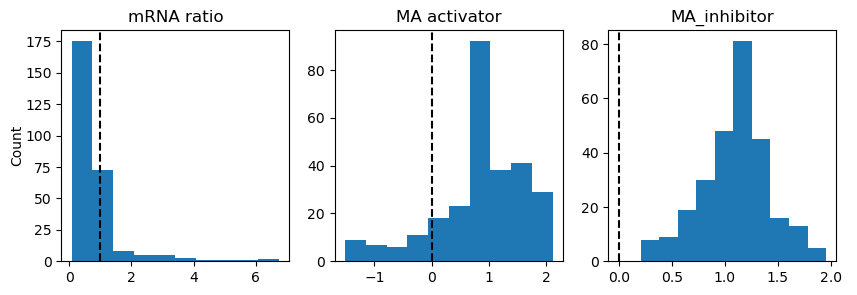

In [4]:
# reads / creates the ratio dataframe
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
if not flags['force_rerun'] and os.path.exists('../data/saved_mRNA_ratios_MA_vals/'+df_name):
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
else:
    ratios_df = mRNA_ratios.calculate_mRNA_ratios_and_MA_values(gene_to_act_inh_iMs[flags['central_gene']][0], gene_to_act_inh_iMs[flags['central_gene']][1], flags)
    ratios_df.to_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name)


# save TF concentration (not sure this is right, but it appears to be close given I don't have raw counts)
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
scaled_df = 2**log_tpm_df / (2**log_tpm_df).sum()

# save of TF concentrations of baseline values
# for now, it's just always crp
# goofy, scaling to same range/units as are used in GAMs
scaled_df.loc['b3357'].to_csv('../data/save_for_GAMs/exported_TF_conc.csv')

# sanity check plot
fig, axs = plt.subplots(1, 3, figsize = (10, 3))
axs[0].hist(ratios_df.actual_mRNA_ratio)
axs[0].set_title('mRNA ratio')
axs[0].axvline(x = 1, c = 'k', ls = '--')
axs[1].hist(ratios_df.MA_activator)
axs[1].set_title('MA activator')
axs[1].axvline(x = 0, c = 'k', ls = '--')
axs[2].hist(ratios_df.MA_inhibitor)
axs[2].set_title('MA_inhibitor')
axs[2].axvline(x = 0, c = 'k', ls = '--')
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel('Count')
plt.show()

# pick KdRNAPCrp value

In [5]:
# currently, this is picked based on assumming cInhibitor = 0 and performing the following:
# 1 a- Limit KdRNAPCrp to be less than KdRNAP
# 2 - Adjust KdRNAPCrp lower until there is no longer an inflection point within the mRNA ratio range of the said gene
# 3 - Adjust KdRNAPCrp to a value that maximizes the linearity and the magnitude of the range
#         a - Basically if just do magnitude it creates an exponentail curve that really only activates at extreme values, the linearity forces this to have more of a dynamic range

grid_constants['KdRNAPCrp'] = po.pick_KdRNAPCrp(ratios_df, grid_constants)

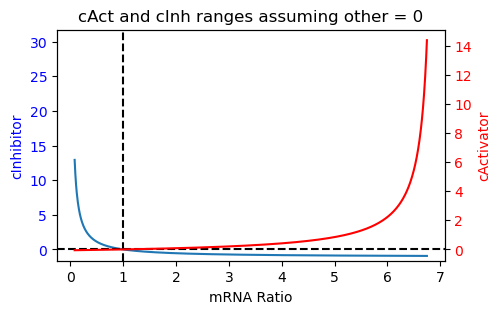

In [6]:
# sanity check plot

# if you get weird results here, look at egulonML/parameter_optimization/0_framework.ipynb
# it does the same thing as the function with plots along the way
# try adjusting the initial guess for the first optimization
# that is line 74 of functions/parameter_optimization.py

# note - This isn't perfect, as it assumes a non-true condition (the other equals zero)
# however, it is a sanity check to see if these values are near-correct
rat_vals = np.linspace(min(ratios_df['actual_mRNA_ratio'].values.flatten()), max(ratios_df['actual_mRNA_ratio'].values.flatten()), 1000)
vals1 = po.mRNA_to_cActivator(rat_vals, KeqOpening = grid_constants['KeqOpening'],
                             KdRNAP = grid_constants['KdRNAP'], RNAP = grid_constants['RNAP'],
                             KdRNAPCrp = grid_constants['KdRNAPCrp'])
vals2 = po.mRNA_to_cInhibitor(rat_vals, KeqOpening = grid_constants['KeqOpening'],
                             KdRNAP = grid_constants['KdRNAP'], RNAP = grid_constants['RNAP'])

fig, ax1 = plt.subplots(figsize = (5, 3))
l1, = ax1.plot(rat_vals, vals2)
plt.xlabel('mRNA Ratio')
ax1.set_ylabel('cInhibitor', color = 'blue')
ax1.tick_params(axis = 'y', labelcolor = 'blue')
ax2 = ax1.twinx()
l2, = ax2.plot(rat_vals, vals1, color = 'red')
ax2.set_ylabel('cActivator', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
ax1.axhline(y = 0, ls = '--', c = 'k')
ax1.axvline(x = 1, ls = '--', c = 'k')
# ZZZ FIX THIS let's rescale cInhibitor (ax1) so that 0 is at the same point
m1, M1 = ax1.get_ylim()
percent1_up = (0 - m1) / (M1 - m1)
m2, M2 = ax2.get_ylim()
percent2_up = (0 - m2) / (M2 - m2)

if percent1_up < percent2_up:
    # zero is higher than it should, so adjust it down by lowering the min
    m1 = percent2_up * M1 / (percent2_up - 1)
    ax1.set_ylim(m1, M1)
else:
    # zero is lower than it should, so adjust it up
    M1 = m1 - (m1 / percent2_up)
    ax1.set_ylim(m1, M1)

plt.title('cAct and cInh ranges assuming other = 0')
plt.show()

# Determine the Best cActivator and cInhibitor Values

## Create the Combined cAct and cInh Grid

### Create the Grid

In [7]:
# DataFrame to hold the Grid
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = ratios_df.index)
grid.loc[:,'mRNA_ratio'] = ratios_df.loc[:,'actual_mRNA_ratio']

# Load the equation
# NOTE: This equation was generated using Mathematica and Dan's Mathematica to Python converter function
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [8]:
# Create lambda functions that we can plug in to
lambda_df = ps.create_lambdas(equation, grid_constants)

cAct_range = {'cActivator': flags['cActivator']} # Use a log10 range
cInh_range = {'cInhibitor': flags['cInhibitor']} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = ps.create_parameter_grid(num_steps = 101, **cAct_range)
    cAct_grid = [[10**x[0]] for x in cAct_grid]
    cInh_grid = ps.create_parameter_grid(num_steps = 101, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function
        cAct_grid[ii] = (cAct_grid[ii][0], (lambda_df.loc['cInhibitor','lambda'](values_tuple))[0])

    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0], cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids

    working_grid = sorted(cAct_grid + cInh_grid)
    
    # Remove negative elements from working_grid
    if flags['neg_grid_toss_OR_zero'] == 'toss':
        working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]
    elif flags['neg_grid_toss_OR_zero'] == 'zero':
        new = []
        for cAct, cInh in working_grid:
            if cAct >= 0 and cInh >= 0:
                new.append((cAct, cInh))
            elif cAct < 0 and cInh < 0:
                new.append((0, 0))
            elif cAct < 0:
                new.append((0, cInh))
            else: # this is cInh is negative and cAct isn't
                new.append((cAct, 0))
        working_grid = new

    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [9]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,0.761506,"[(0, 0.1), (0, 0.11220184543019636), (0, 0.125..."
control__wt_glc__2,0.760611,"[(0, 0.1), (0, 0.11220184543019636), (0, 0.125..."
fur__wt_dpd__1,0.24403,"[(0, 0.1), (0, 0.11220184543019636), (0, 0.125..."
fur__wt_dpd__2,0.27251,"[(0, 0.1), (0, 0.11220184543019636), (0, 0.125..."
fur__wt_fe__1,0.687311,"[(0, 0.1), (0, 0.11220184543019636), (0, 0.125..."


### Scatter Condition's Grid with Histograms

/tmp/ipykernel_1013795/466169581.py:26: RuntimeWarning: divide by zero encountered in log10
  x_bins = np.logspace(np.log10(min(x)), np.log10(max(x)), 50)
/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


Text(0.5, 0.98, 'Condition: control__wt_glc__1')

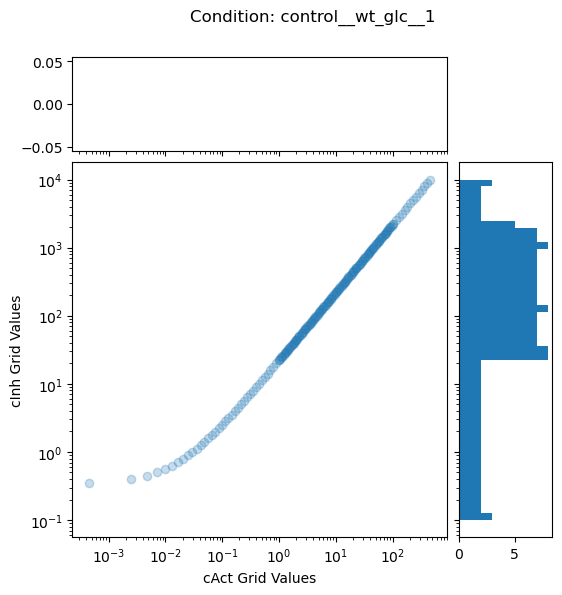

In [10]:
i = 0 # The integer corresponding to the condition of interest index

x = [cAct for (cAct, _) in grid.iloc[i,1]]
y = [cInh for (_, cInh) in grid.iloc[i,1]]

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# the scatter plot:
ax.scatter(x, y, alpha=0.25)

x_bins = np.logspace(np.log10(min(x)), np.log10(max(x)), 50)
y_bins = np.logspace(np.log10(min(y)), np.log10(max(y)), 50)

ax_histx.hist(x, bins=x_bins)
ax_histy.hist(y, bins=y_bins, orientation='horizontal')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('cAct Grid Values')
ax.set_ylabel('cInh Grid Values')

fig.suptitle('Condition: '+str(grid.index[i]))

## Setup and Run the GA

In [ ]:
# Create fitness and individual objects
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               shape = (len(grid),), # Number of conditions
               dtype = np.dtype([('act', float), ('inh', float)]), # Custom dtype
               fitness = creator.fitness)

# Import toolbox
toolbox = base.Toolbox()

# Register the individual and population functions
toolbox.register(alias = 'individual',
                 function = ga.generate_individual,
                 individual_class = creator.individual,
                 grid = grid.grid,
                 rng = rng)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

# Register the evaluation function
toolbox.register(alias = 'evaluate',
                function = ga.spearman_objective,
                MA_df = ratios_df.loc[:,['MA_activator','MA_inhibitor']])

# Register the selection algorithm
toolbox.register(alias = "select", 
                 function = tools.selNSGA2, 
                 nd = 'log') 
# I've been using selNSGA2 since it seems to run faster
#toolbox.register("select", tools.selSPEA2)

# Register the mutation function
toolbox.register(alias = 'mutate', 
                 function = ga.mutate, 
                 prob = flags['mt_prob'], 
                 grid = grid.grid, 
                 rng = rng)

# Register the crossover function
cx_prob = 0.6 # NOTE: These values were chosen based on brute_force.ipynb
toolbox.register(alias = "mate", 
                 function = ga.crossover, 
                 prob = flags['cx_prob'],
                 rng = rng)

# Set the statistics to record the best individual score of each generation in 
# the logbook
stats = tools.Statistics(key=lambda ind: np.subtract(ind.fitness.values[0],
                                                     ind.fitness.values[1]))

# Run the GA
pop, logbook = ga.mu_plus_lambda(pop = toolbox.population(n = flags['n_ind']), 
                                 toolbox = toolbox, 
                                 rng = rng, 
                                 mu = flags['mu'], 
                                 lambda_ = flags['lambda_'], 
                                 cxpb = flags['cxpb'], 
                                 mutpb = flags['mutpb'], 
                                 n_gen = flags['n_gen'], 
                                 stats = stats, 
                                 verbose = flags['verbose'])

### Check GA Results

In [ ]:
total_score, total_sort = ga.best_individual(pop)
total_score[total_sort[-1]]

In [ ]:
fig, (ax1, ax2) = ga.scatter_individual(ind_one = pop[total_sort[-1]],
                                     MA = ratios_df.loc[:,['MA_activator','MA_inhibitor']],
                                     GA_parameters = flags)

fig.show()

## Run the Greedy Algorithm

In [ ]:
greedy_pop = ga.greedy_algorithm(base_individual = pop[total_sort[-1]], 
                                 n_iterations = flags['n_iter'],
                                 grid = grid.grid,
                                 toolbox = toolbox,
                                 max_steps = flags['max_steps'],
                                 n_rounds = flags['n_rounds'])

greedy_score, greedy_sort = ga.best_individual(greedy_pop)
greedy_score[greedy_sort[-1]]

In [ ]:
greedy_voting = ga.voting(population = greedy_pop,
                          grid = grid.grid)

# Convert from condition integer index to grid tuple to create mean_ind
mean_ind = creator.individual(greedy_pop[greedy_sort[-1]])
for i, _ in enumerate(mean_ind):
    mean_ind[i] = grid.grid[i][int(greedy_voting._mean[i])]

mean_ind.fitness.values = toolbox.evaluate(mean_ind)
print(np.subtract(mean_ind.fitness.values[0], mean_ind.fitness.values[1]))

In [ ]:
fig, (ax1, ax2) = ga.scatter_individual(ind_one = greedy_pop[greedy_sort[-1]],
                                        MA = ratios_df.loc[:,['MA_activator','MA_inhibitor']],
                                        GA_parameters = None)

fig.show()

### Convert Chosen Individual to DataFrame

In [ ]:
GAMs_individual = greedy_pop[greedy_sort[-1]] # TODO: EDIT THIS USING FLAGS?

vals_for_GAMs = pd.DataFrame(index = ratios_df.index,
                             columns = ['cAct', 'cInh'],)

vals_for_GAMs.cAct = list(GAMs_individual['act'])
vals_for_GAMs.cInh = list(GAMs_individual['inh'])

### Save for GAMs (Avoid Overwriting Existing Files)

In [ ]:
# save for GAMs
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
file_out = '../data/save_for_GAMs/'+df_name
vals_for_GAMs.to_csv(file_out)

# run GAMs

In [ ]:
# first let's merge together the files
files_use = []
if flags['run_on_all']:
    files = os.listdir('../data/save_for_GAMs/')
    for f in files:
        if 'composite' in f: continue
        if 'zerod'+str(flags['use_zerod_A_matrix']) not in f: continue
        files_use.append(f)
else:
    for sample in flags['limit_samples']:
        f_name = sample+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
        if os.path.exists('../data/save_for_GAMs/'+f_name):
            files_use.append(f_name)
for f in files_use:
    act_df = pd.DataFrame(index = ratios_df.index)
    inh_df = pd.DataFrame(index = ratios_df.index)
    for file in files_use:
        gene_name = file.split('_')[0]
        act_df[gene_name] = pd.read_csv('../data/save_for_GAMs/'+file)['cAct'].values
        inh_df[gene_name] = pd.read_csv('../data/save_for_GAMs/'+file)['cInh'].values
act_df.to_csv('../data/save_for_GAMs/composite_cAct_vals.csv')
inh_df.to_csv('../data/save_for_GAMs/composite_cInh_vals.csv')

In [ ]:
# call GAMs
_ = subprocess.call('gams cAct_model', shell = True, cwd = '../GAMs')
_ = subprocess.call('gams cInh_model', shell = True, cwd = '../GAMs')

In [ ]:
# look at GAMs results

# load in cActivators
saved_cActivators = pd.read_csv('../data/save_for_GAMs/composite_cAct_vals.csv', index_col = 0)

# GAMS calculated cActivators
kd_df = 10**pd.read_csv('../data/GAMS_output/cAct_Kd_results.csv', index_col = 0).astype(float).T
saved_cActivators = saved_cActivators[kd_df.columns]
TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
saved_cActivators = saved_cActivators.loc[TF_conc_df.columns]
calc_cAct = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
cActs = []
for sample in calc_cAct.columns:
    for gene in calc_cAct.index:
        calc_cAct.at[gene, sample] = TF_conc_df[sample].values[0] / kd_df[gene].values[0]
calc_cAct = calc_cAct.T

# plotting
saved = []
calc = []
labels = []
gene_to_color = {}
cmap = cm.get_cmap('tab20')
color_opts = iter(cmap.colors)
colors = []
for gene in calc_cAct.columns:
    if gene not in gene_to_color:
        gene_to_color.update({gene : next(color_opts)})
    color = gene_to_color[gene]
    for sample in calc_cAct.index:
        saved.append(saved_cActivators.loc[sample][gene])
        calc.append(calc_cAct.loc[sample][gene])
        labels.append(gene+', '+sample)
        colors.append(color)
fig, axs = plt.subplots(1, 2, figsize = (6, 3))
scatter = axs[0].scatter(saved, calc, c = colors)
axs[0].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
axs[0].set_xlabel('cActivators from GA')
axs[0].set_ylabel('Recalculated cActivators post GAMS')
corr = np.corrcoef(saved, calc)
axs[0].set_title('Correlation = {:.2f}'.format(corr[1][0]))
#plt.yscale('log')
#plt.xscale('log')

# Create an empty list to store legend handles and labels
legend_elements = []
for label, color in gene_to_color.items():
    legend_elements.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 10, markerfacecolor = color, label = label))
axs[0].legend(handles = legend_elements, loc = 'lower right')


# now plot cInhibitor
# load in cActivators
saved_cActivators = pd.read_csv('../data/save_for_GAMs/composite_cInh_vals.csv', index_col = 0)

# GAMS calculated cActivators
kd_df = 10**pd.read_csv('../data/GAMS_output/cInh_Kd_results.csv', index_col = 0).astype(float).T
saved_cActivators = saved_cActivators[kd_df.columns]
TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
saved_cActivators = saved_cActivators.loc[TF_conc_df.columns]
calc_cInh = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
cActs = []
for sample in calc_cInh.columns:
    for gene in calc_cInh.index:
        calc_cInh.at[gene, sample] = TF_conc_df[sample].values[0] / kd_df[gene].values[0]
calc_cInh = calc_cInh.T

# plotting
saved = []
calc = []
labels = []
gene_to_color = {}
cmap = cm.get_cmap('tab20')
color_opts = iter(cmap.colors)
colors = []
for gene in calc_cAct.columns:
    if gene not in gene_to_color:
        gene_to_color.update({gene : next(color_opts)})
    color = gene_to_color[gene]
    for sample in calc_cAct.index:
        saved.append(saved_cActivators.loc[sample][gene])
        calc.append(calc_cInh.loc[sample][gene])
        labels.append(gene+', '+sample)
        colors.append(color)
scatter = axs[1].scatter(saved, calc, c = colors)
axs[1].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
axs[1].set_xlabel('cInhibitors from GA')
axs[1].set_ylabel('Recalculated cInhibitors post GAMS')
corr = np.corrcoef(saved, calc)
axs[1].set_title('Correlation = {:.2f}'.format(corr[1][0]))
#plt.yscale('log')
#plt.xscale('log')
fig.tight_layout()
plt.show()

# convert back to mRNA ratios

In [ ]:
# there are a few types of re-converted mRNA ratios
# 1 the GA cActivator and cInhibitor, should get perfect recreation
# 2 using recreated cActivator and cInhibitor from the GAMs solution
    # to do this, I need to get cInhibitor working on GAMs, which I believe will be the same thing with different data

    
# I feel like I already did this and push merged over it, but I'll do it again
# I need recreated cActivators and cInhibitors
shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
corrs = []
max_mRNA = 0
plt.figure(figsize = (4, 4))
for gene in calc_cAct.columns:
    grid = gene_to_grid_constants[gene]
    
    df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
    
    
    recon_mRNA = po.cActivator_cInhibitor_to_mRNA(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared],
                                            RNAP = grid['RNAP'], KdRNAP = grid['KdRNAP'],
                                            KdRNAPCrp = grid['KdRNAPCrp'], KeqOpening = grid['KeqOpening'])

    actual_mRNA = ratios_df.loc[shared]['actual_mRNA_ratio'].values.flatten()
    if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
        max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        
    corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
    corrs.append(corr[0][1])
    plt.scatter(actual_mRNA, recon_mRNA, label = gene, alpha = 0.5)
plt.plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
plt.legend()
plt.title('Average Correlation = {:.2f}'.format(np.mean(corrs)))
plt.xlabel('Actual mRNA Ratio')
plt.ylabel('Reconstructed mRNA Ratio from GAMS')
plt.show()

# plotting